In [ ]:

# things we will need to do stuff in this notebook
import numpy as np
import pandas as pd
from scipy import stats
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")


# a helper function
def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency/Affinity Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn)
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
    

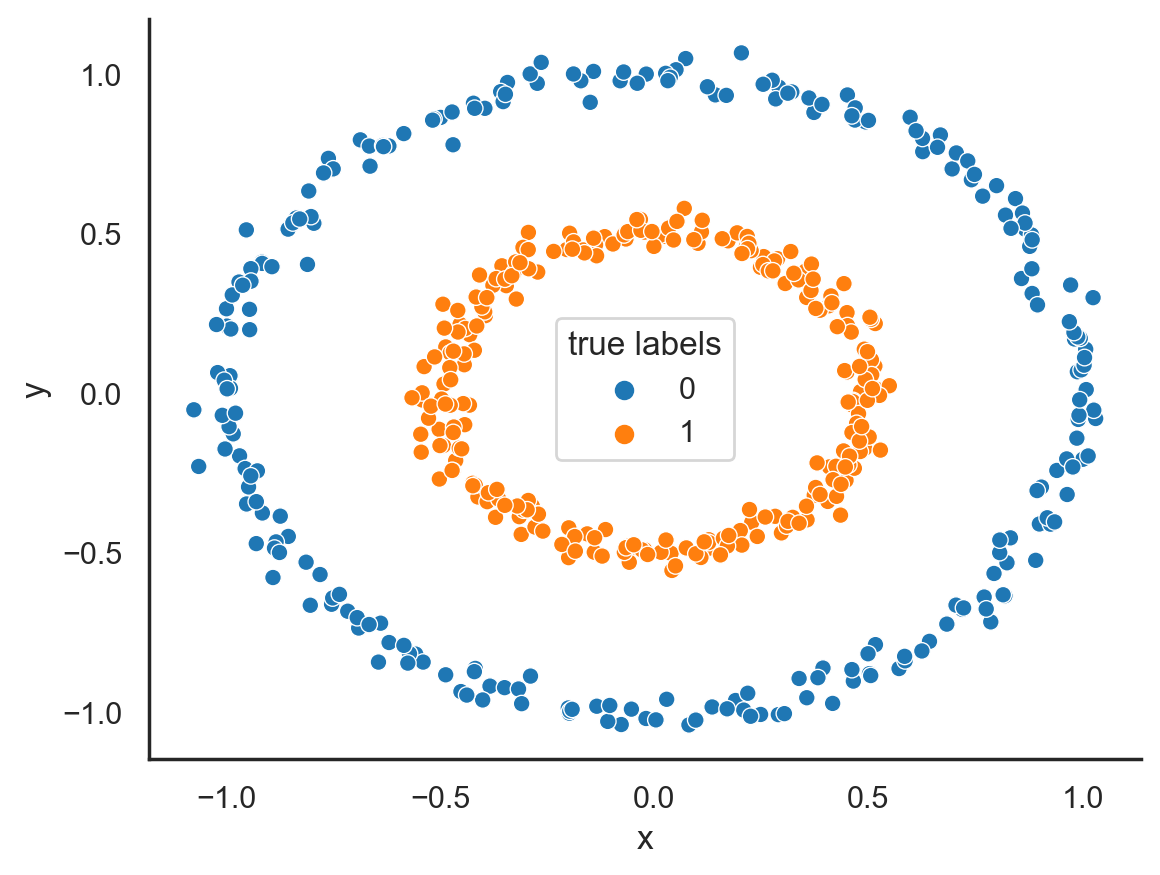

In [2]:
data, labels = make_circles(n_samples=500, factor=0.5, noise=0.03, random_state=619)
#data, labels = make_moons(n_samples=500, noise=0.07, random_state=619)

df = pd.DataFrame(data,columns=['x','y'])
df['true labels']=labels
df = df.sort_values(by='true labels')

sns.scatterplot(data=df, x='x', y='y', hue='true labels');
sns.despine()

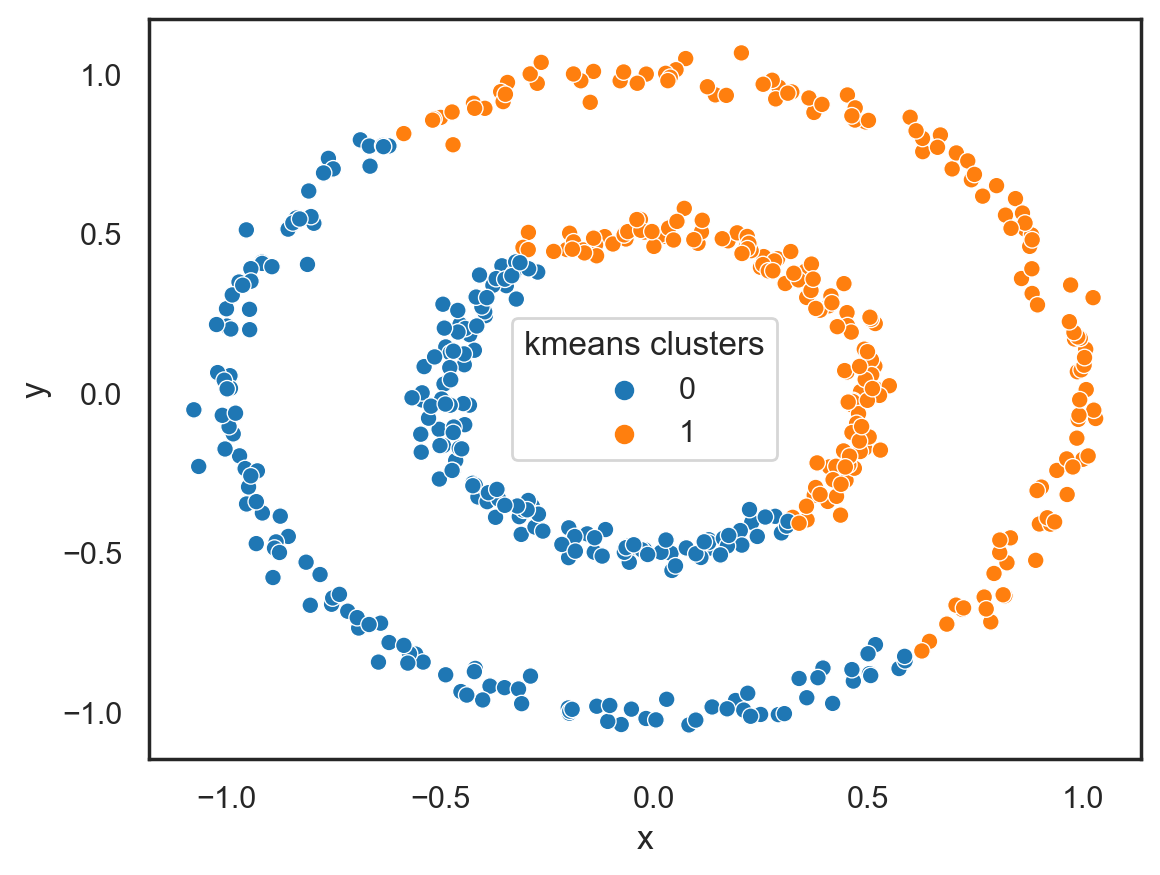

In [4]:
df['kmeans clusters'] = KMeans(n_clusters=2).fit_predict(df[['x','y']])
sns.scatterplot(data=df, x='x', y='y', hue='kmeans clusters');

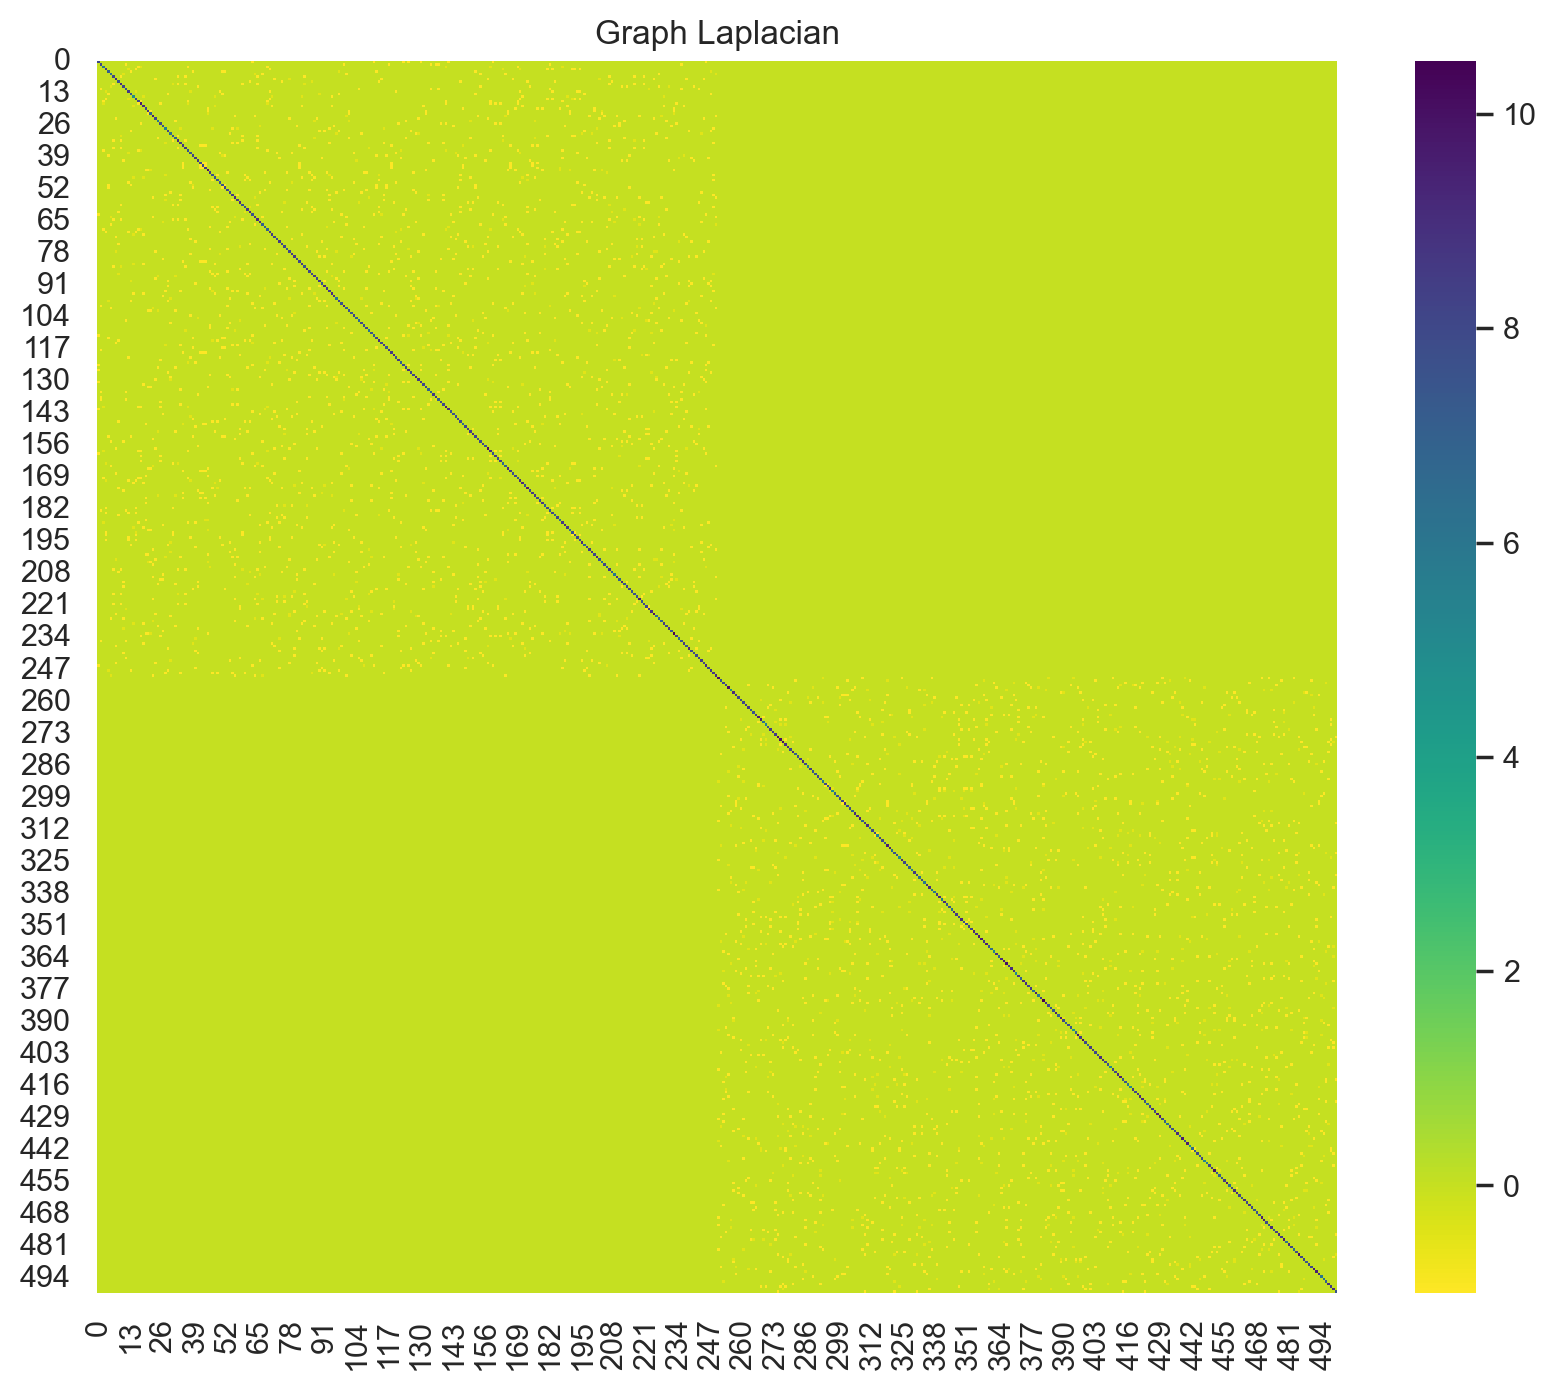

In [5]:


# lets do some manual spectral clustering as a demo
 
graph_laplacian = generate_graph_laplacian(df=df[['x','y']], nn=8)


# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');



eigenvals, eigenvcts = eigh(graph_laplacian)

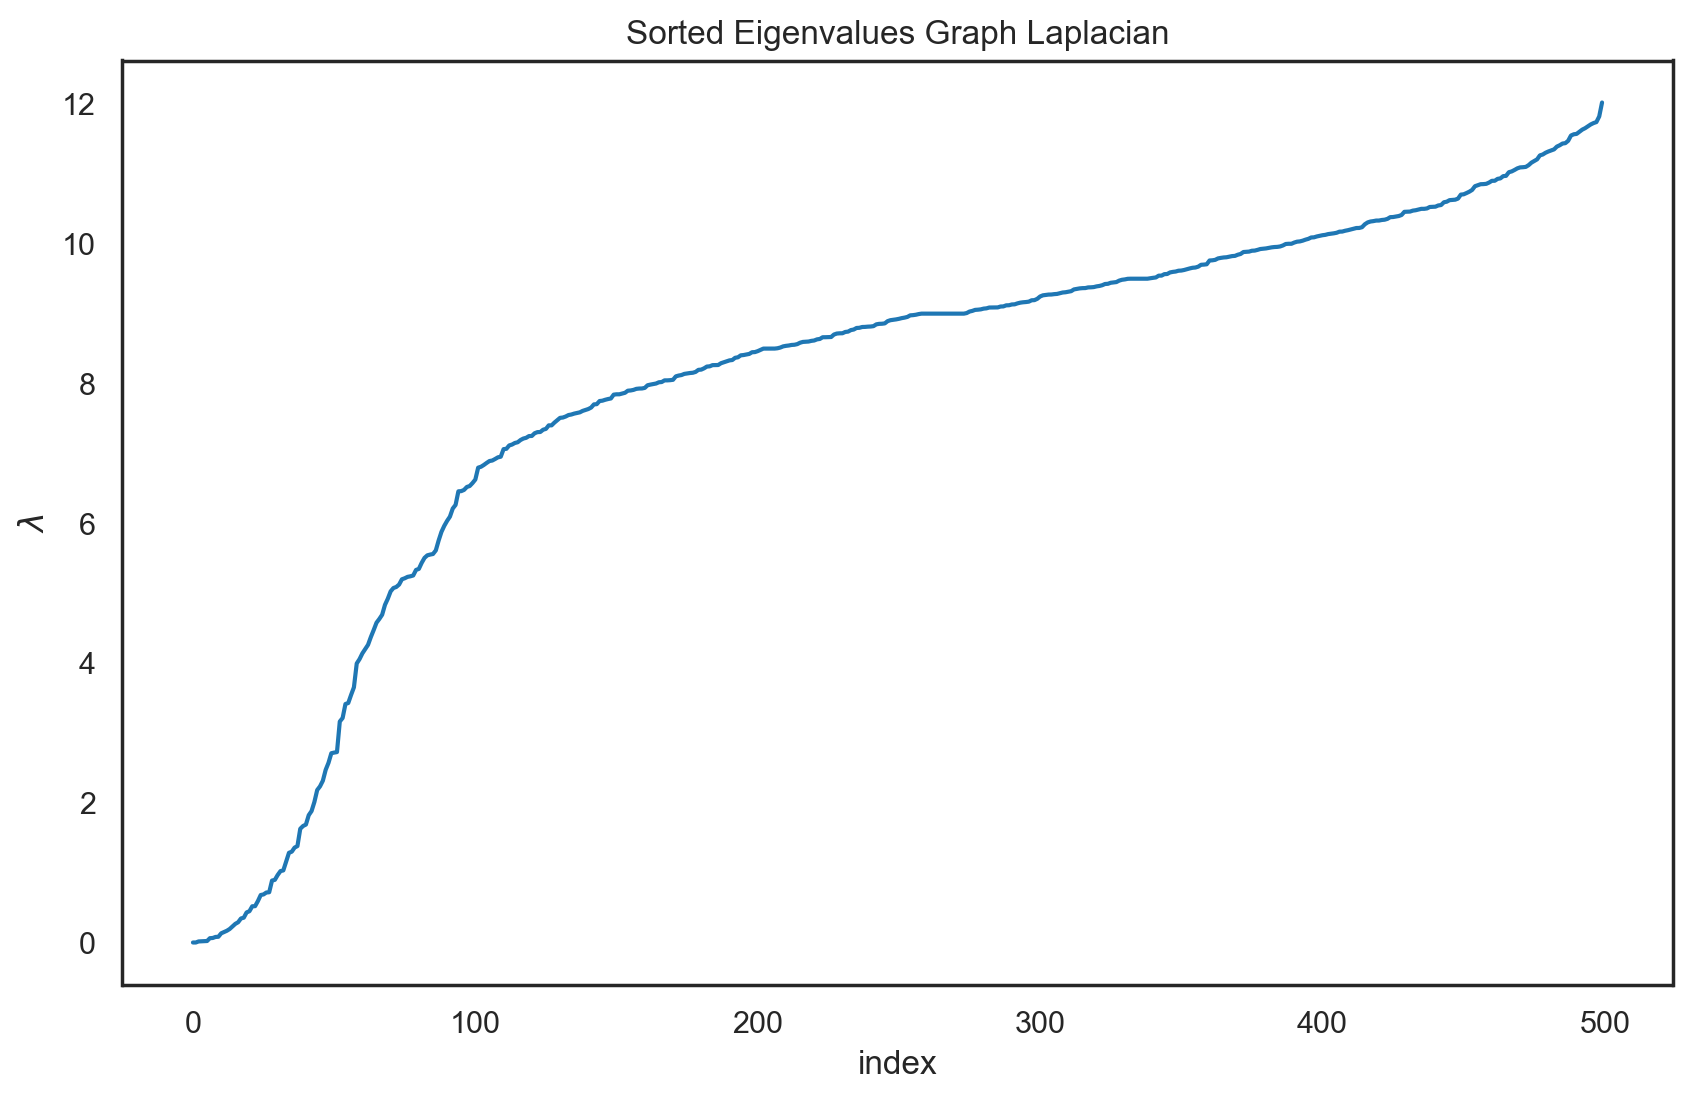

In [6]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(eigenvals)), y=eigenvals, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

In [7]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5) # arbitrary number close to zero
zeroeigens = eigenvals[zero_eigenvals_index]
nzeros = len(zeroeigens)
zeroeigens

array([[0.],
       [0.]])

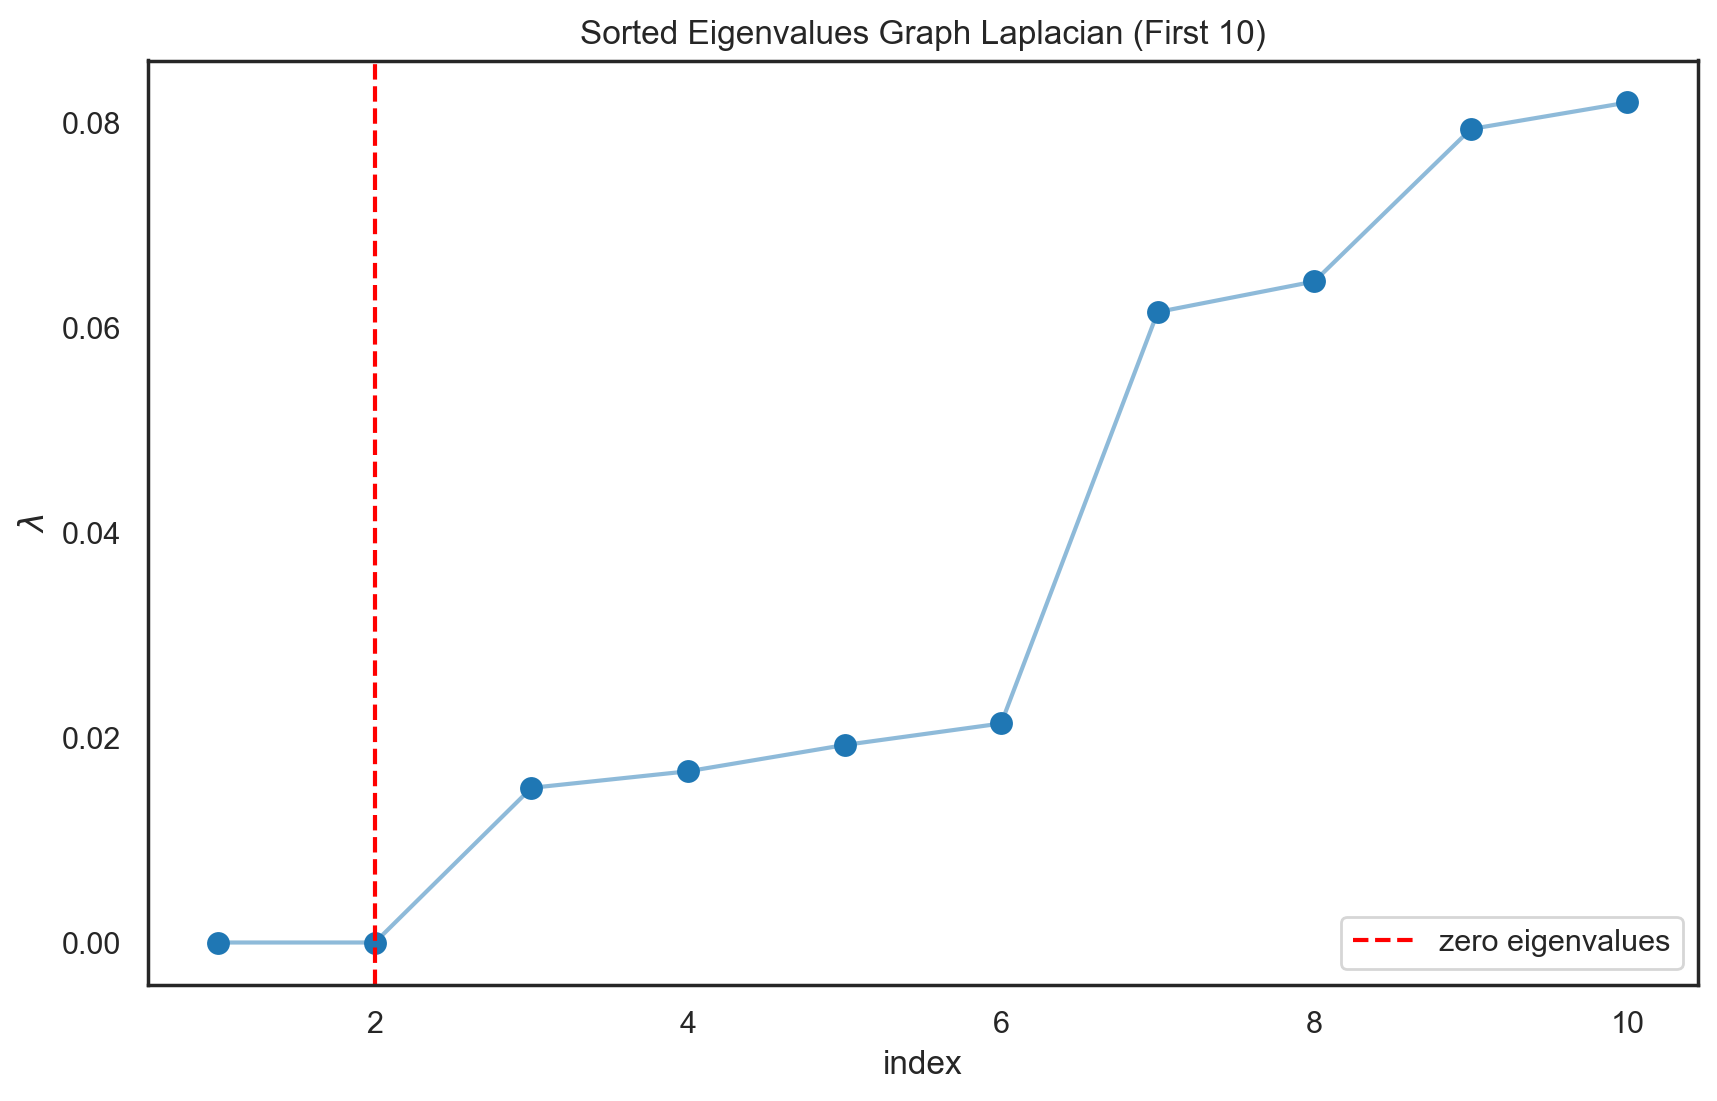

In [9]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1,index_lim+1), y=eigenvals[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1,index_lim+1), y=eigenvals[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=nzeros, color='r', label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [10]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1
0,0.063246,0.0
1,0.063246,0.0
2,0.063246,0.0
3,0.063246,0.0
4,0.063246,0.0


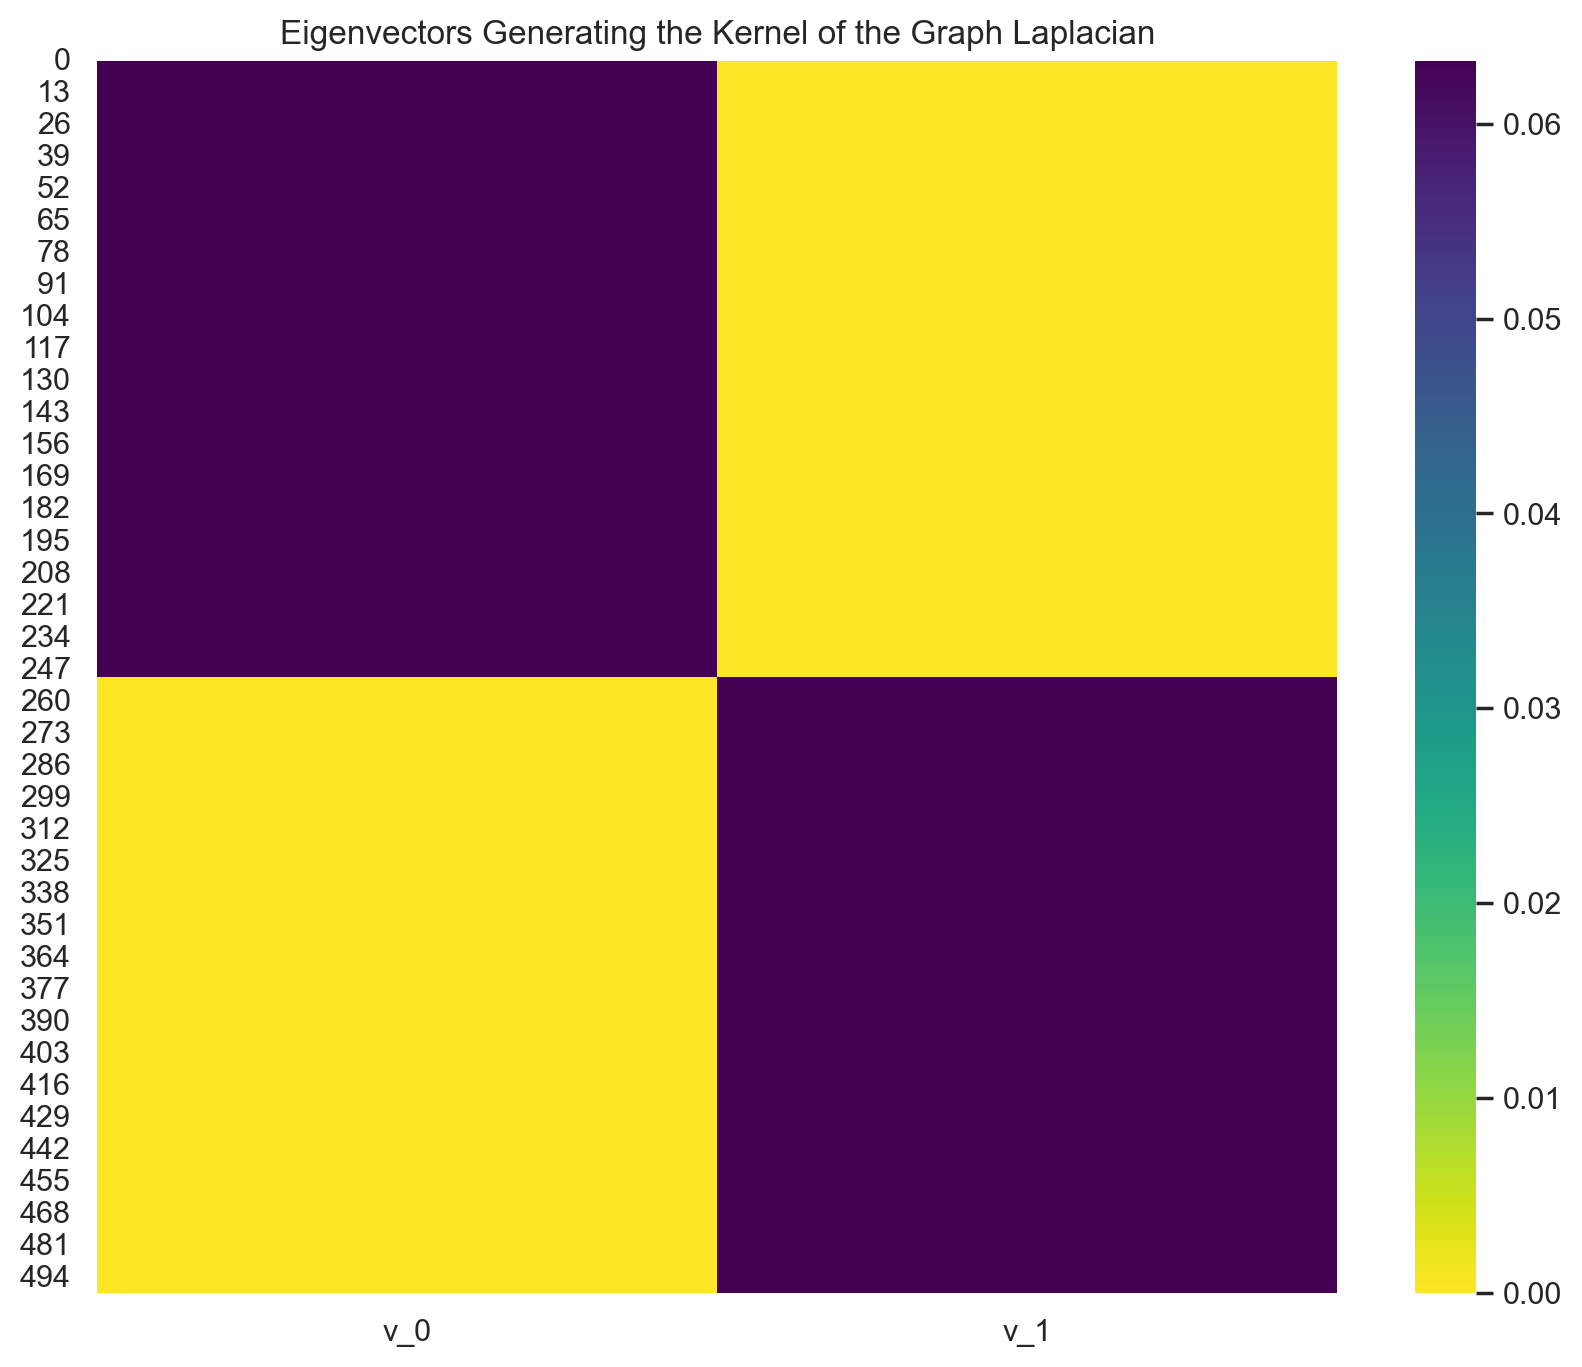

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');

In [12]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)


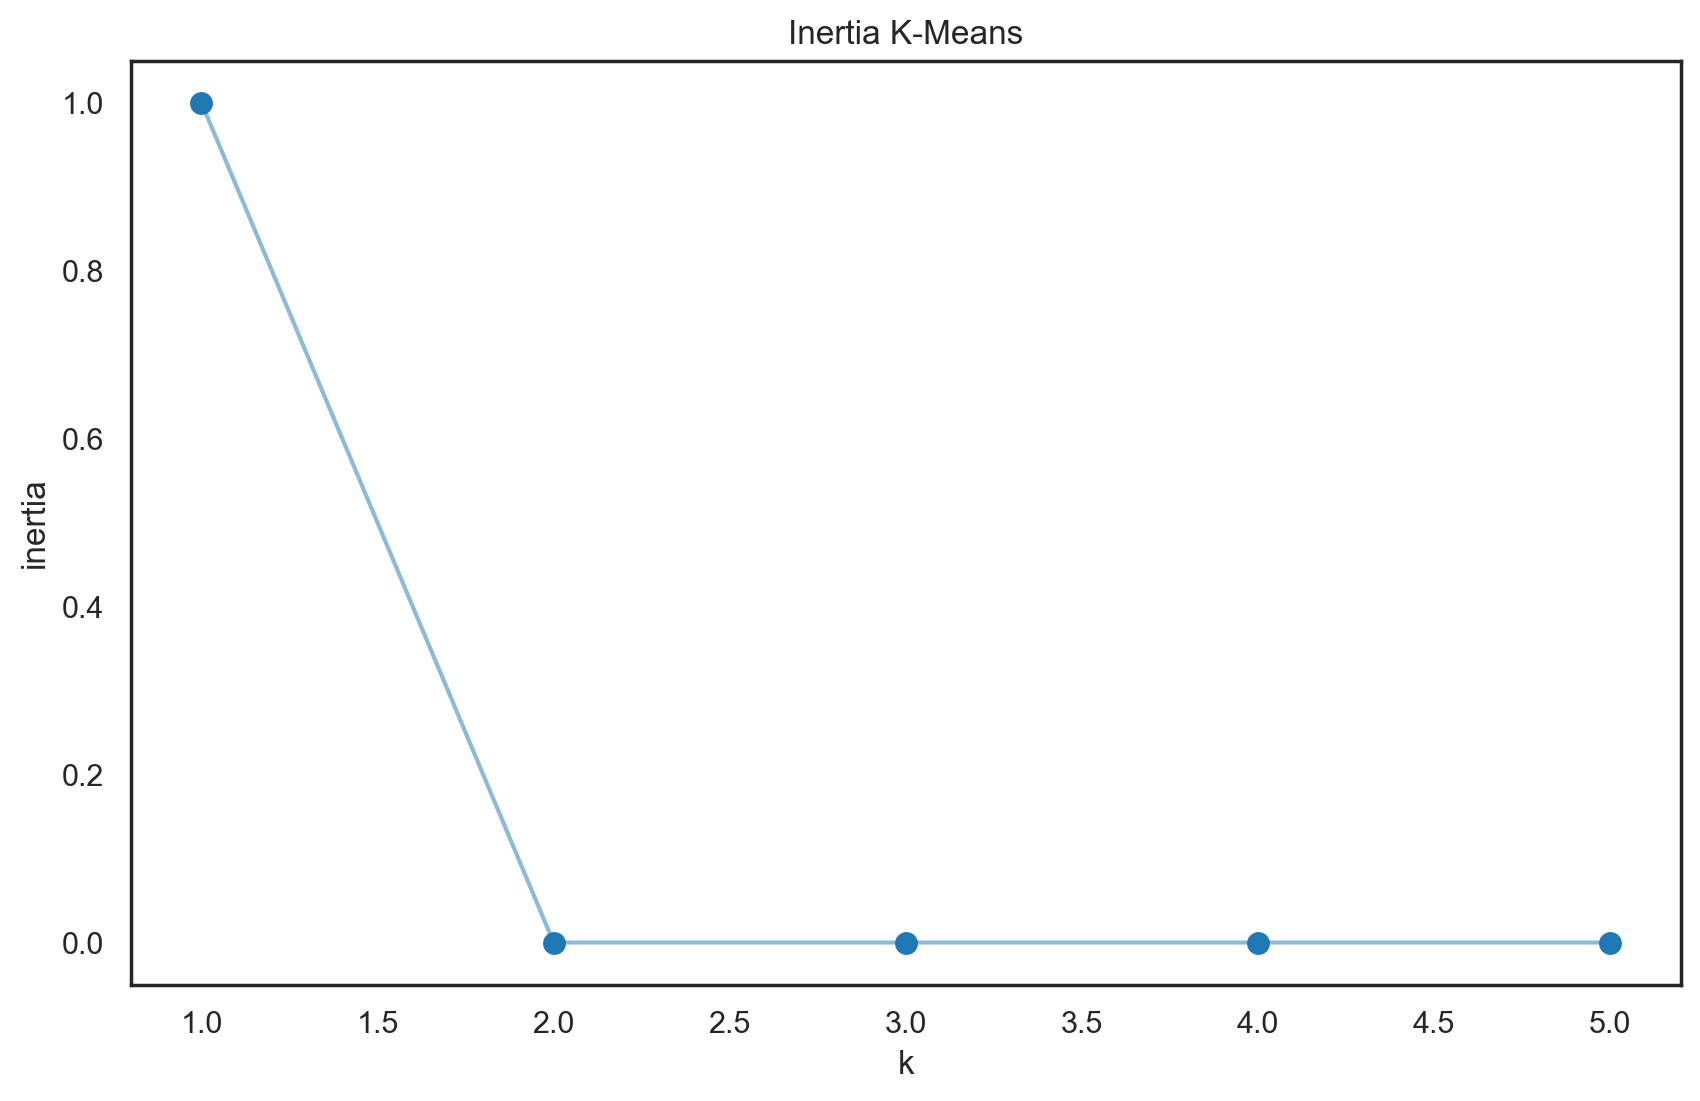

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

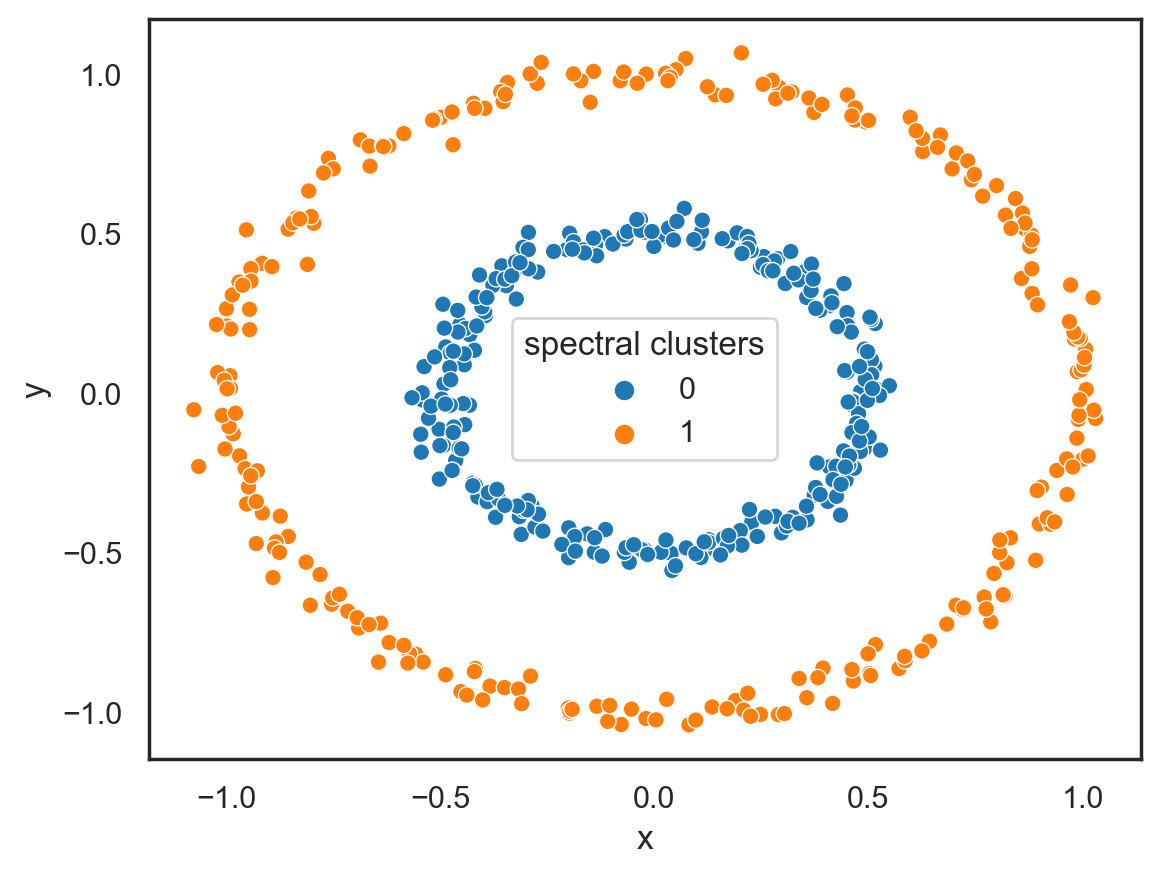

In [14]:
clust = KMeans(n_clusters=2).fit_predict(proj_df)
df['spectral clusters'] = clust
sns.scatterplot(data=df, x='x', y='y', hue='spectral clusters');

# Things to play with

1. There is more than one way to make a spectral clustering!  This zero-eigenvalue way really only works well with perfectly seperated clusters.  That's becuase the number of zero eigenvalues is equal to the number of connected components in the dataset... so if any nearest neighbors affinity entries cross over between clusters you are screwed. See what happens when you add more noise to the dataset! Likewise see what happens when you cahnge the number of nearest neighbors when we construct the laplacian.
1. Another method in spectral clustering is that in some circumstances you might be able to use the Fiedler eigenvector (the smallest non-zero eigenvalue) as a simple biclustering... if the vector value is above a threshold it's cluster 1, otherwise cluster 0.
1. Instead of this hacked together code above, try using the Scikit-learn to do this for real!  Their code is MUCH more reliable... but you still have to create the affinity matrix first! https://scikit-learn.org/stable/modules/generated/sklearn.cluster.spectral_clustering.html
